# SignVision — Improve model with Data Augmentation
This notebook shows a step-by-step process to:
1. Configure aggressive on-the-fly augmentation.
2. Visualize augmented samples.
3. Train a robust CNN using augmented data + class weights.
4. Save the best model and plot training curves.

Assumptions:
- Data directories: `dataset/train` and `dataset/val`
- Class folders are numeric: `0`, `1`, `2`, `3`, `4`


## Setup: imports and random seeds
We import TensorFlow, Keras helpers, and utilities. We set a seed for reproducibility (note: full determinism is not always possible).


In [13]:
# Code: imports and seed
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.18.0


## Paths and basic dataset check
Make sure `train_dir` and `val_dir` exist. We quickly list classes detected by Keras.


In [14]:
# Code: dataset paths & quick check
train_dir = 'E:/Downloads/sign_language/SignVision/data_processed/crops/train'
val_dir   = 'E:/Downloads/sign_language/SignVision/data_processed/crops/val'

assert os.path.isdir(train_dir), f"Train dir not found: {train_dir}"
assert os.path.isdir(val_dir), f"Val dir not found: {val_dir}"

print("Train subfolders:", sorted(os.listdir(train_dir)))
print("Val subfolders:", sorted(os.listdir(val_dir)))


Train subfolders: ['0', '1', '2', '3', '4']
Val subfolders: ['0', '1', '2', '3', '4']


## Configure aggressive augmentation
We create an `ImageDataGenerator` for training with strong augmentations (rotation, shift, zoom, brightness, flips). Validation uses only rescaling.


In [28]:
# Code: augmentation configuration
IMG_SIZE = (128, 128)   # slightly larger helps model learn detail; adjust as needed
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.7, 1.3),
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


## Create Keras generators
We use `class_mode='categorical'` so labels are one-hot vectors (model will use `categorical_crossentropy`).


In [29]:
# Code: create generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',   # <-- returns integer labels (e.g. 0,1,2,...)
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',   # <-- integer labels
    shuffle=False
)

print("Train classes:", train_gen.class_indices)
print("Val classes:  ", val_gen.class_indices)
num_classes = train_gen.num_classes
print("Num classes:", num_classes)


Found 103 images belonging to 5 classes.
Found 31 images belonging to 5 classes.
Train classes: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
Val classes:   {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
Num classes: 5


## Visualize augmented examples
This helps ensure augmentation looks reasonable and that we don't accidentally destroy sign semantics.


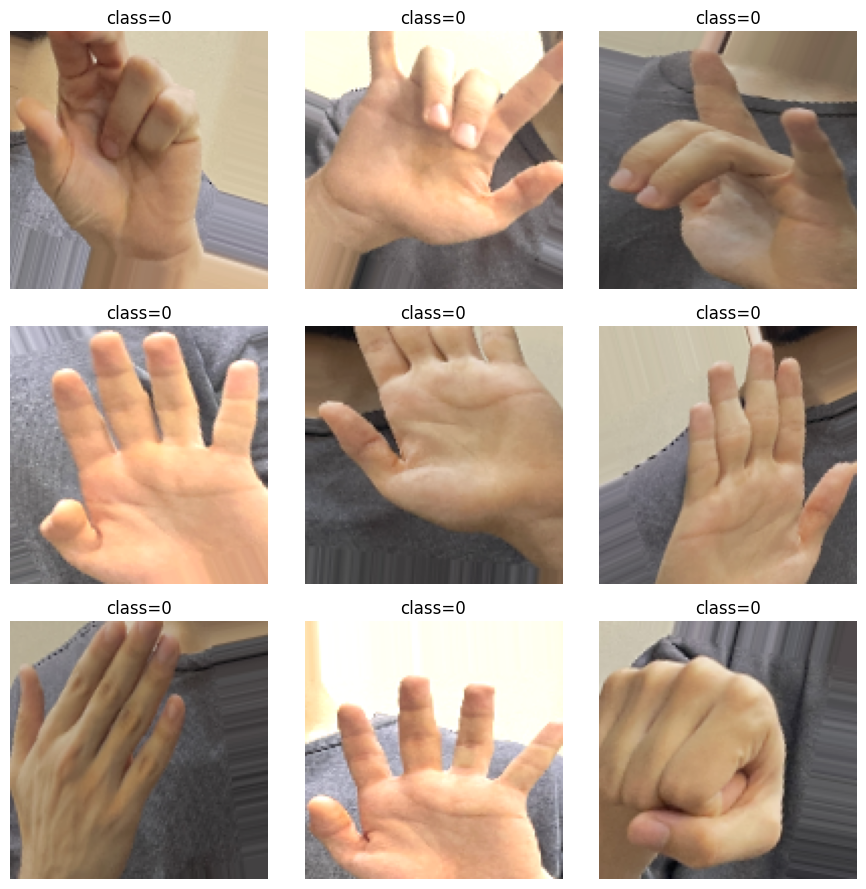

In [30]:
# Code: visualize augmented samples
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_gen)  # one batch
n = min(9, x_batch.shape[0])

plt.figure(figsize=(9,9))
for i in range(n):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    cls = np.argmax(y_batch[i])
    plt.title(f"class={cls}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## Compute class weights to balance classes
Class weights will emphasize under-represented classes during training.


In [31]:
labels = train_gen.classes  # integer array of length N_samples
class_weights_values = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights_values))
print("Computed class weights:", class_weights)

Computed class weights: {0: 1.2117647058823529, 1: 1.03, 2: 1.1444444444444444, 3: 1.2875, 4: 0.64375}


## Model architecture
A compact CNN (Conv-BN-Pool blocks) with dropout for regularization. Output size uses `train_gen.num_classes`.
We choose this smaller model for faster iteration; you can swap MobileNetV2 later.


In [33]:
# Code: build model
from tensorflow.keras import layers, models, optimizers

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=8e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,181 (12.61 MB)

 Trainable params: 3,305,733 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

## Callbacks
We add early stopping and a ModelCheckpoint that saves the best model in `.keras` format.


In [34]:
# Code: callbacks
os.makedirs("models", exist_ok=True)
checkpoint_cb = ModelCheckpoint(
    "models/signvision_aug_best.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


## Train the model with on-the-fly augmentation and class weights
We train for some epochs and rely on augmentation producing more variety per epoch.
If you have limited GPU, reduce `EPOCHS`.


In [36]:
# Code: training
EPOCHS = 25

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/25


InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[1.        , 0.9686275 , 0.83921576],
         [1.        , 0.9725491 , 0.8470589 ],
         [1.        , 0.9725491 , 0.854902  ],
         ...,
         [0.86274517, 0.6666667 , 0.54901963],
         [0.6       , 0.47058827, 0.39607847],
         [0.26666668, 0.19215688, 0.15686275]],

        [[0.9921569 , 0.96470594, 0.8352942 ],
         [0.9921569 , 0.96470594, 0.8352942 ],
         [0.9921569 , 0.96470594, 0.8352942 ],
         ...,
         [0.6117647 , 0.46274513, 0.40000004],
         [0.35686275, 0.27450982, 0.24313727],
         [0.21568629, 0.16078432, 0.15294118]],

        [[0.9921569 , 0.96470594, 0.8352942 ],
         [0.9921569 , 0.96470594, 0.8352942 ],
         [0.9921569 , 0.96470594, 0.8352942 ],
         ...,
         [0.2392157 , 0.15294118, 0.13333334],
         [0.20392159, 0.15686275, 0.14901961],
         [0.20000002, 0.15686275, 0.15294118]],

        ...,

        [[0.6784314 , 0.5137255 , 0.35686275],
         [0.6784314 , 0.5137255 , 0.35686275],
         [0.6901961 , 0.5254902 , 0.37254903],
         ...,
         [0.33333334, 0.33333334, 0.33333334],
         [0.33333334, 0.33333334, 0.33333334],
         [0.33333334, 0.33333334, 0.33333334]],

        [[0.6784314 , 0.5137255 , 0.35686275],
         [0.6784314 , 0.5137255 , 0.35686275],
         [0.69803923, 0.5372549 , 0.3803922 ],
         ...,
         [0.33333334, 0.33333334, 0.33333334],
         [0.33333334, 0.33333334, 0.33333334],
         [0.33333334, 0.33333334, 0.33333334]],

        [[0.6784314 , 0.5137255 , 0.35686275],
         [0.6784314 , 0.5137255 , 0.35686275],
         [0.70980394, 0.54509807, 0.38823533],
         ...,
         [0.33333334, 0.33333334, 0.33333334],
         [0.33333334, 0.33333334, 0.33333334],
         [0.33333334, 0.33333334, 0.33333334]]],


       [[[0.3803922 , 0.3254902 , 0.2627451 ],
         [0.40000004, 0.3372549 , 0.2784314 ],
         [0.41176474, 0.34901962, 0.2901961 ],
         ...,
         [0.6392157 , 0.61960787, 0.5568628 ],
         [0.63529414, 0.6117647 , 0.5529412 ],
         [0.63529414, 0.6117647 , 0.5529412 ]],

        [[0.34509805, 0.29411766, 0.227451  ],
         [0.3529412 , 0.3019608 , 0.2392157 ],
         [0.36862746, 0.3137255 , 0.24705884],
         ...,
         [0.6392157 , 0.6156863 , 0.5529412 ],
         [0.63529414, 0.6117647 , 0.5529412 ],
         [0.63529414, 0.6117647 , 0.5529412 ]],

        [[0.35686275, 0.30588236, 0.24313727],
         [0.34117648, 0.2901961 , 0.227451  ],
         [0.3372549 , 0.28235295, 0.21960786],
         ...,
         [0.6392157 , 0.6156863 , 0.5529412 ],
         [0.63529414, 0.6117647 , 0.5529412 ],
         [0.6313726 , 0.60784316, 0.5529412 ]],

        ...,

        [[0.22352943, 0.22352943, 0.227451  ],
         [0.227451  , 0.227451  , 0.23529413],
         [0.2392157 , 0.2392157 , 0.24313727],
         ...,
         [0.41176474, 0.3137255 , 0.23529413],
         [0.4156863 , 0.31764707, 0.2392157 ],
         [0.41960788, 0.32156864, 0.24313727]],

        [[0.22352943, 0.22352943, 0.227451  ],
         [0.23137257, 0.23137257, 0.2392157 ],
         [0.2392157 , 0.2392157 , 0.24313727],
         ...,
         [0.40784317, 0.30980393, 0.23137257],
         [0.40784317, 0.30980393, 0.23137257],
         [0.40784317, 0.30980393, 0.23137257]],

        [[0.227451  , 0.227451  , 0.23137257],
         [0.23529413, 0.23529413, 0.2392157 ],
         [0.21960786, 0.21960786, 0.227451  ],
         ...,
         [0.41176474, 0.3137255 , 0.24313727],
         [0.41176474, 0.3137255 , 0.2392157 ],
         [0.41176474, 0.3137255 , 0.23529413]]],


       [[[0.5411765 , 0.4039216 , 0.29411766],
         [0.54901963, 0.41176474, 0.30588236],
         [0.5294118 , 0.3921569 , 0.28627452],
         ...,
         [1.        , 1.        , 0.90196085],
         [1.        , 1.        , 0.90196085],
         [1.        , 1.        , 0.9058824 ]],

        [[0.5411765 , 0.4039216 , 0.29411766],
         [0.54509807, 0.40784317, 0.3019608 ],
         [0.53333336, 0.39607847, 0.2901961 ],
         ...,
         [1.        , 1.        , 0.90196085],
         [1.        , 1.        , 0.90196085],
         [1.        , 1.        , 0.90196085]],

        [[0.5411765 , 0.4039216 , 0.29411766],
         [0.54509807, 0.40784317, 0.3019608 ],
         [0.5411765 , 0.4039216 , 0.29411766],
         ...,
         [1.        , 1.        , 0.90196085],
         [1.        , 1.        , 0.90196085],
         [1.        , 1.        , 0.90196085]],

        ...,

        [[0.46274513, 0.46274513, 0.47058827],
         [0.46274513, 0.46274513, 0.47058827],
         [0.46274513, 0.46274513, 0.47058827],
         ...,
         [0.72156864, 0.5529412 , 0.42352945],
         [0.72156864, 0.5529412 , 0.42352945],
         [0.72156864, 0.5529412 , 0.42352945]],

        [[0.45098042, 0.45098042, 0.46274513],
         [0.44705886, 0.44705886, 0.454902  ],
         [0.4431373 , 0.4431373 , 0.45098042],
         ...,
         [0.72156864, 0.5529412 , 0.42352945],
         [0.72156864, 0.5529412 , 0.42352945],
         [0.72156864, 0.5529412 , 0.42352945]],

        [[0.43137258, 0.43137258, 0.4431373 ],
         [0.43137258, 0.43137258, 0.4431373 ],
         [0.43137258, 0.43137258, 0.4431373 ],
         ...,
         [0.72156864, 0.5529412 , 0.42352945],
         [0.72156864, 0.5529412 , 0.42352945],
         [0.72156864, 0.5529412 , 0.42352945]]],


       ...,


       [[[0.41960788, 0.4156863 , 0.44705886],
         [0.41176474, 0.40784317, 0.43529415],
         [0.41176474, 0.40784317, 0.43137258],
         ...,
         [0.8352942 , 0.8313726 , 0.854902  ],
         [0.8352942 , 0.8313726 , 0.854902  ],
         [0.8352942 , 0.8313726 , 0.854902  ]],

        [[0.41960788, 0.4156863 , 0.44705886],
         [0.41176474, 0.40784317, 0.43529415],
         [0.41176474, 0.40784317, 0.43137258],
         ...,
         [0.8352942 , 0.8313726 , 0.854902  ],
         [0.8352942 , 0.8313726 , 0.854902  ],
         [0.8352942 , 0.8313726 , 0.854902  ]],

        [[0.41960788, 0.4156863 , 0.44705886],
         [0.41176474, 0.40784317, 0.43529415],
         [0.41176474, 0.40784317, 0.43137258],
         ...,
         [0.8352942 , 0.8313726 , 0.854902  ],
         [0.8352942 , 0.8313726 , 0.854902  ],
         [0.8352942 , 0.8313726 , 0.854902  ]],

        ...,

        [[0.3529412 , 0.34117648, 0.34509805],
         [0.35686275, 0.34509805, 0.3529412 ],
         [0.37254903, 0.36078432, 0.3647059 ],
         ...,
         [0.40000004, 0.39607847, 0.41960788],
         [0.40000004, 0.39607847, 0.41960788],
         [0.40000004, 0.39607847, 0.41960788]],

        [[0.34117648, 0.33333334, 0.3372549 ],
         [0.32156864, 0.3137255 , 0.31764707],
         [0.33333334, 0.32156864, 0.3254902 ],
         ...,
         [0.47058827, 0.47058827, 0.48235297],
         [0.47058827, 0.47058827, 0.48235297],
         [0.47058827, 0.47058827, 0.48235297]],

        [[0.34509805, 0.3372549 , 0.34117648],
         [0.33333334, 0.32156864, 0.3254902 ],
         [0.31764707, 0.30588236, 0.3137255 ],
         ...,
         [0.41960788, 0.40784317, 0.41176474],
         [0.41960788, 0.40784317, 0.41176474],
         [0.41960788, 0.40784317, 0.41176474]]],


       [[[0.7568628 , 0.7137255 , 0.64705884],
         [0.7568628 , 0.7137255 , 0.64705884],
         [0.7568628 , 0.7137255 , 0.64705884],
         ...,
         [0.27450982, 0.26666668, 0.2784314 ],
         [0.2509804 , 0.24313727, 0.25490198],
         [0.23529413, 0.227451  , 0.2392157 ]],

        [[0.75294125, 0.70980394, 0.64705884],
         [0.75294125, 0.70980394, 0.64705884],
         [0.7568628 , 0.70980394, 0.64705884],
         ...,
         [0.2784314 , 0.27058825, 0.28235295],
         [0.25490198, 0.24705884, 0.25882354],
         [0.24705884, 0.2392157 , 0.2509804 ]],

        [[0.7490196 , 0.72156864, 0.654902  ],
         [0.75294125, 0.72156864, 0.6509804 ],
         [0.75294125, 0.7176471 , 0.6509804 ],
         ...,
         [0.28235295, 0.27450982, 0.28627452],
         [0.2901961 , 0.28235295, 0.29411766],
         [0.29411766, 0.28627452, 0.29803923]],

        ...,

        [[0.86666673, 0.8078432 , 0.6745098 ],
         [0.86666673, 0.8078432 , 0.6745098 ],
         [0.8705883 , 0.8117648 , 0.6784314 ],
         ...,
         [0.31764707, 0.30980393, 0.3137255 ],
         [0.29411766, 0.28627452, 0.2901961 ],
         [0.29803923, 0.2901961 , 0.29803923]],

        [[0.86666673, 0.8078432 , 0.6745098 ],
         [0.86666673, 0.8078432 , 0.6745098 ],
         [0.8705883 , 0.8117648 , 0.6784314 ],
         ...,
         [0.27450982, 0.26666668, 0.27058825],
         [0.2784314 , 0.27058825, 0.27450982],
         [0.29803923, 0.2901961 , 0.29411766]],

        [[0.86666673, 0.8078432 , 0.6745098 ],
         [0.86666673, 0.8078432 , 0.6745098 ],
         [0.8705883 , 0.8117648 , 0.6784314 ],
         ...,
         [0.2784314 , 0.27058825, 0.27450982],
         [0.2901961 , 0.28235295, 0.2901961 ],
         [0.29803923, 0.2901961 , 0.29411766]]],


       [[[0.4431373 , 0.34117648, 0.2784314 ],
         [0.454902  , 0.3529412 , 0.28627452],
         [0.4666667 , 0.36078432, 0.29411766],
         ...,
         [0.854902  , 0.8196079 , 0.7137255 ],
         [0.854902  , 0.8196079 , 0.7137255 ],
         [0.85098046, 0.81568635, 0.70980394]],

        [[0.38431376, 0.28235295, 0.23529413],
         [0.39607847, 0.29411766, 0.24313727],
         [0.40784317, 0.30588236, 0.25490198],
         ...,
         [0.854902  , 0.8196079 , 0.7137255 ],
         [0.854902  , 0.8196079 , 0.7137255 ],
         [0.85098046, 0.81568635, 0.70980394]],

        [[0.32941177, 0.23529413, 0.19215688],
         [0.34117648, 0.24313727, 0.20000002],
         [0.3529412 , 0.2509804 , 0.20784315],
         ...,
         [0.854902  , 0.8196079 , 0.7137255 ],
         [0.85098046, 0.81568635, 0.70980394],
         [0.8470589 , 0.8117648 , 0.7058824 ]],

        ...,

        [[0.16078432, 0.16862746, 0.16470589],
         [0.16862746, 0.1764706 , 0.17254902],
         [0.16862746, 0.1764706 , 0.17254902],
         ...,
         [0.7843138 , 0.6431373 , 0.47058827],
         [0.78823537, 0.6509804 , 0.4784314 ],
         [0.78823537, 0.65882355, 0.48627454]],

        [[0.16078432, 0.16862746, 0.16470589],
         [0.16862746, 0.1764706 , 0.17254902],
         [0.16862746, 0.1764706 , 0.17254902],
         ...,
         [0.7294118 , 0.58431375, 0.42352945],
         [0.7411765 , 0.59607846, 0.43529415],
         [0.7568628 , 0.6117647 , 0.4431373 ]],

        [[0.16470589, 0.17254902, 0.16862746],
         [0.16862746, 0.1764706 , 0.17254902],
         [0.16862746, 0.17254902, 0.17254902],
         ...,
         [0.67058825, 0.5372549 , 0.38823533],
         [0.6862745 , 0.54901963, 0.39607847],
         [0.69803923, 0.5568628 , 0.4039216 ]]]], dtype=float32), array([4., 2., 2., 3., 2., 3., 3., 4., 4., 2., 3., 2., 4., 3., 4., 1., 4.,
       3., 3., 4., 2., 1., 0., 2., 1., 0., 1., 4., 4., 4., 4., 4.],
      dtype=float32)).
Traceback (most recent call last):

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\data\util\nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(
           ^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1541, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1570, in _tf_data_flatten_up_to
    _tf_data_assert_shallow_structure(shallow_tree, input_tree)

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1427, in _tf_data_assert_shallow_structure
    raise ValueError(

ValueError: The two structures don't have the same sequence length. Input structure has length 2, while shallow structure has length 3.


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\PC\venv\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 206, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[1.        , 0.9686275 , 0.83921576],
         [1.        , 0.9725491 , 0.8470589 ],
         [1.        , 0.9725491 , 0.854902  ],
         ...,
         [0.86274517, 0.6666667 , 0.54901963],
         [0.6       , 0.47058827, 0.39607847],
         [0.26666668, 0.19215688, 0.15686275]],

        [[0.9921569 , 0.96470594, 0.8352942 ],
         [0.9921569 , 0.96470594, 0.8352942 ],
         [0.9921569 , 0.96470594, 0.8352942 ],
         ...,
         [0.6117647 , 0.46274513, 0.40000004],
         [0.35686275, 0.27450982, 0.24313727],
         [0.21568629, 0.16078432, 0.15294118]],

        [[0.9921569 , 0.96470594, 0.8352942 ],
         [0.9921569 , 0.96470594, 0.8352942 ],
         [0.9921569 , 0.96470594, 0.8352942 ],
         ...,
         [0.2392157 , 0.15294118, 0.13333334],
         [0.20392159, 0.15686275, 0.14901961],
         [0.20000002, 0.15686275, 0.15294118]],

        ...,

        [[0.6784314 , 0.5137255 , 0.35686275],
         [0.6784314 , 0.5137255 , 0.35686275],
         [0.6901961 , 0.5254902 , 0.37254903],
         ...,
         [0.33333334, 0.33333334, 0.33333334],
         [0.33333334, 0.33333334, 0.33333334],
         [0.33333334, 0.33333334, 0.33333334]],

        [[0.6784314 , 0.5137255 , 0.35686275],
         [0.6784314 , 0.5137255 , 0.35686275],
         [0.69803923, 0.5372549 , 0.3803922 ],
         ...,
         [0.33333334, 0.33333334, 0.33333334],
         [0.33333334, 0.33333334, 0.33333334],
         [0.33333334, 0.33333334, 0.33333334]],

        [[0.6784314 , 0.5137255 , 0.35686275],
         [0.6784314 , 0.5137255 , 0.35686275],
         [0.70980394, 0.54509807, 0.38823533],
         ...,
         [0.33333334, 0.33333334, 0.33333334],
         [0.33333334, 0.33333334, 0.33333334],
         [0.33333334, 0.33333334, 0.33333334]]],


       [[[0.3803922 , 0.3254902 , 0.2627451 ],
         [0.40000004, 0.3372549 , 0.2784314 ],
         [0.41176474, 0.34901962, 0.2901961 ],
         ...,
         [0.6392157 , 0.61960787, 0.5568628 ],
         [0.63529414, 0.6117647 , 0.5529412 ],
         [0.63529414, 0.6117647 , 0.5529412 ]],

        [[0.34509805, 0.29411766, 0.227451  ],
         [0.3529412 , 0.3019608 , 0.2392157 ],
         [0.36862746, 0.3137255 , 0.24705884],
         ...,
         [0.6392157 , 0.6156863 , 0.5529412 ],
         [0.63529414, 0.6117647 , 0.5529412 ],
         [0.63529414, 0.6117647 , 0.5529412 ]],

        [[0.35686275, 0.30588236, 0.24313727],
         [0.34117648, 0.2901961 , 0.227451  ],
         [0.3372549 , 0.28235295, 0.21960786],
         ...,
         [0.6392157 , 0.6156863 , 0.5529412 ],
         [0.63529414, 0.6117647 , 0.5529412 ],
         [0.6313726 , 0.60784316, 0.5529412 ]],

        ...,

        [[0.22352943, 0.22352943, 0.227451  ],
         [0.227451  , 0.227451  , 0.23529413],
         [0.2392157 , 0.2392157 , 0.24313727],
         ...,
         [0.41176474, 0.3137255 , 0.23529413],
         [0.4156863 , 0.31764707, 0.2392157 ],
         [0.41960788, 0.32156864, 0.24313727]],

        [[0.22352943, 0.22352943, 0.227451  ],
         [0.23137257, 0.23137257, 0.2392157 ],
         [0.2392157 , 0.2392157 , 0.24313727],
         ...,
         [0.40784317, 0.30980393, 0.23137257],
         [0.40784317, 0.30980393, 0.23137257],
         [0.40784317, 0.30980393, 0.23137257]],

        [[0.227451  , 0.227451  , 0.23137257],
         [0.23529413, 0.23529413, 0.2392157 ],
         [0.21960786, 0.21960786, 0.227451  ],
         ...,
         [0.41176474, 0.3137255 , 0.24313727],
         [0.41176474, 0.3137255 , 0.2392157 ],
         [0.41176474, 0.3137255 , 0.23529413]]],


       [[[0.5411765 , 0.4039216 , 0.29411766],
         [0.54901963, 0.41176474, 0.30588236],
         [0.5294118 , 0.3921569 , 0.28627452],
         ...,
         [1.        , 1.        , 0.90196085],
         [1.        , 1.        , 0.90196085],
         [1.        , 1.        , 0.9058824 ]],

        [[0.5411765 , 0.4039216 , 0.29411766],
         [0.54509807, 0.40784317, 0.3019608 ],
         [0.53333336, 0.39607847, 0.2901961 ],
         ...,
         [1.        , 1.        , 0.90196085],
         [1.        , 1.        , 0.90196085],
         [1.        , 1.        , 0.90196085]],

        [[0.5411765 , 0.4039216 , 0.29411766],
         [0.54509807, 0.40784317, 0.3019608 ],
         [0.5411765 , 0.4039216 , 0.29411766],
         ...,
         [1.        , 1.        , 0.90196085],
         [1.        , 1.        , 0.90196085],
         [1.        , 1.        , 0.90196085]],

        ...,

        [[0.46274513, 0.46274513, 0.47058827],
         [0.46274513, 0.46274513, 0.47058827],
         [0.46274513, 0.46274513, 0.47058827],
         ...,
         [0.72156864, 0.5529412 , 0.42352945],
         [0.72156864, 0.5529412 , 0.42352945],
         [0.72156864, 0.5529412 , 0.42352945]],

        [[0.45098042, 0.45098042, 0.46274513],
         [0.44705886, 0.44705886, 0.454902  ],
         [0.4431373 , 0.4431373 , 0.45098042],
         ...,
         [0.72156864, 0.5529412 , 0.42352945],
         [0.72156864, 0.5529412 , 0.42352945],
         [0.72156864, 0.5529412 , 0.42352945]],

        [[0.43137258, 0.43137258, 0.4431373 ],
         [0.43137258, 0.43137258, 0.4431373 ],
         [0.43137258, 0.43137258, 0.4431373 ],
         ...,
         [0.72156864, 0.5529412 , 0.42352945],
         [0.72156864, 0.5529412 , 0.42352945],
         [0.72156864, 0.5529412 , 0.42352945]]],


       ...,


       [[[0.41960788, 0.4156863 , 0.44705886],
         [0.41176474, 0.40784317, 0.43529415],
         [0.41176474, 0.40784317, 0.43137258],
         ...,
         [0.8352942 , 0.8313726 , 0.854902  ],
         [0.8352942 , 0.8313726 , 0.854902  ],
         [0.8352942 , 0.8313726 , 0.854902  ]],

        [[0.41960788, 0.4156863 , 0.44705886],
         [0.41176474, 0.40784317, 0.43529415],
         [0.41176474, 0.40784317, 0.43137258],
         ...,
         [0.8352942 , 0.8313726 , 0.854902  ],
         [0.8352942 , 0.8313726 , 0.854902  ],
         [0.8352942 , 0.8313726 , 0.854902  ]],

        [[0.41960788, 0.4156863 , 0.44705886],
         [0.41176474, 0.40784317, 0.43529415],
         [0.41176474, 0.40784317, 0.43137258],
         ...,
         [0.8352942 , 0.8313726 , 0.854902  ],
         [0.8352942 , 0.8313726 , 0.854902  ],
         [0.8352942 , 0.8313726 , 0.854902  ]],

        ...,

        [[0.3529412 , 0.34117648, 0.34509805],
         [0.35686275, 0.34509805, 0.3529412 ],
         [0.37254903, 0.36078432, 0.3647059 ],
         ...,
         [0.40000004, 0.39607847, 0.41960788],
         [0.40000004, 0.39607847, 0.41960788],
         [0.40000004, 0.39607847, 0.41960788]],

        [[0.34117648, 0.33333334, 0.3372549 ],
         [0.32156864, 0.3137255 , 0.31764707],
         [0.33333334, 0.32156864, 0.3254902 ],
         ...,
         [0.47058827, 0.47058827, 0.48235297],
         [0.47058827, 0.47058827, 0.48235297],
         [0.47058827, 0.47058827, 0.48235297]],

        [[0.34509805, 0.3372549 , 0.34117648],
         [0.33333334, 0.32156864, 0.3254902 ],
         [0.31764707, 0.30588236, 0.3137255 ],
         ...,
         [0.41960788, 0.40784317, 0.41176474],
         [0.41960788, 0.40784317, 0.41176474],
         [0.41960788, 0.40784317, 0.41176474]]],


       [[[0.7568628 , 0.7137255 , 0.64705884],
         [0.7568628 , 0.7137255 , 0.64705884],
         [0.7568628 , 0.7137255 , 0.64705884],
         ...,
         [0.27450982, 0.26666668, 0.2784314 ],
         [0.2509804 , 0.24313727, 0.25490198],
         [0.23529413, 0.227451  , 0.2392157 ]],

        [[0.75294125, 0.70980394, 0.64705884],
         [0.75294125, 0.70980394, 0.64705884],
         [0.7568628 , 0.70980394, 0.64705884],
         ...,
         [0.2784314 , 0.27058825, 0.28235295],
         [0.25490198, 0.24705884, 0.25882354],
         [0.24705884, 0.2392157 , 0.2509804 ]],

        [[0.7490196 , 0.72156864, 0.654902  ],
         [0.75294125, 0.72156864, 0.6509804 ],
         [0.75294125, 0.7176471 , 0.6509804 ],
         ...,
         [0.28235295, 0.27450982, 0.28627452],
         [0.2901961 , 0.28235295, 0.29411766],
         [0.29411766, 0.28627452, 0.29803923]],

        ...,

        [[0.86666673, 0.8078432 , 0.6745098 ],
         [0.86666673, 0.8078432 , 0.6745098 ],
         [0.8705883 , 0.8117648 , 0.6784314 ],
         ...,
         [0.31764707, 0.30980393, 0.3137255 ],
         [0.29411766, 0.28627452, 0.2901961 ],
         [0.29803923, 0.2901961 , 0.29803923]],

        [[0.86666673, 0.8078432 , 0.6745098 ],
         [0.86666673, 0.8078432 , 0.6745098 ],
         [0.8705883 , 0.8117648 , 0.6784314 ],
         ...,
         [0.27450982, 0.26666668, 0.27058825],
         [0.2784314 , 0.27058825, 0.27450982],
         [0.29803923, 0.2901961 , 0.29411766]],

        [[0.86666673, 0.8078432 , 0.6745098 ],
         [0.86666673, 0.8078432 , 0.6745098 ],
         [0.8705883 , 0.8117648 , 0.6784314 ],
         ...,
         [0.2784314 , 0.27058825, 0.27450982],
         [0.2901961 , 0.28235295, 0.2901961 ],
         [0.29803923, 0.2901961 , 0.29411766]]],


       [[[0.4431373 , 0.34117648, 0.2784314 ],
         [0.454902  , 0.3529412 , 0.28627452],
         [0.4666667 , 0.36078432, 0.29411766],
         ...,
         [0.854902  , 0.8196079 , 0.7137255 ],
         [0.854902  , 0.8196079 , 0.7137255 ],
         [0.85098046, 0.81568635, 0.70980394]],

        [[0.38431376, 0.28235295, 0.23529413],
         [0.39607847, 0.29411766, 0.24313727],
         [0.40784317, 0.30588236, 0.25490198],
         ...,
         [0.854902  , 0.8196079 , 0.7137255 ],
         [0.854902  , 0.8196079 , 0.7137255 ],
         [0.85098046, 0.81568635, 0.70980394]],

        [[0.32941177, 0.23529413, 0.19215688],
         [0.34117648, 0.24313727, 0.20000002],
         [0.3529412 , 0.2509804 , 0.20784315],
         ...,
         [0.854902  , 0.8196079 , 0.7137255 ],
         [0.85098046, 0.81568635, 0.70980394],
         [0.8470589 , 0.8117648 , 0.7058824 ]],

        ...,

        [[0.16078432, 0.16862746, 0.16470589],
         [0.16862746, 0.1764706 , 0.17254902],
         [0.16862746, 0.1764706 , 0.17254902],
         ...,
         [0.7843138 , 0.6431373 , 0.47058827],
         [0.78823537, 0.6509804 , 0.4784314 ],
         [0.78823537, 0.65882355, 0.48627454]],

        [[0.16078432, 0.16862746, 0.16470589],
         [0.16862746, 0.1764706 , 0.17254902],
         [0.16862746, 0.1764706 , 0.17254902],
         ...,
         [0.7294118 , 0.58431375, 0.42352945],
         [0.7411765 , 0.59607846, 0.43529415],
         [0.7568628 , 0.6117647 , 0.4431373 ]],

        [[0.16470589, 0.17254902, 0.16862746],
         [0.16862746, 0.1764706 , 0.17254902],
         [0.16862746, 0.17254902, 0.17254902],
         ...,
         [0.67058825, 0.5372549 , 0.38823533],
         [0.6862745 , 0.54901963, 0.39607847],
         [0.69803923, 0.5568628 , 0.4039216 ]]]], dtype=float32), array([4., 2., 2., 3., 2., 3., 3., 4., 4., 2., 3., 2., 4., 3., 4., 1., 4.,
       3., 3., 4., 2., 1., 0., 2., 1., 0., 1., 4., 4., 4., 4., 4.],
      dtype=float32)).


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_24815]

## Plot accuracy and loss curves
Visualize training/validation accuracy and loss to check for overfitting.


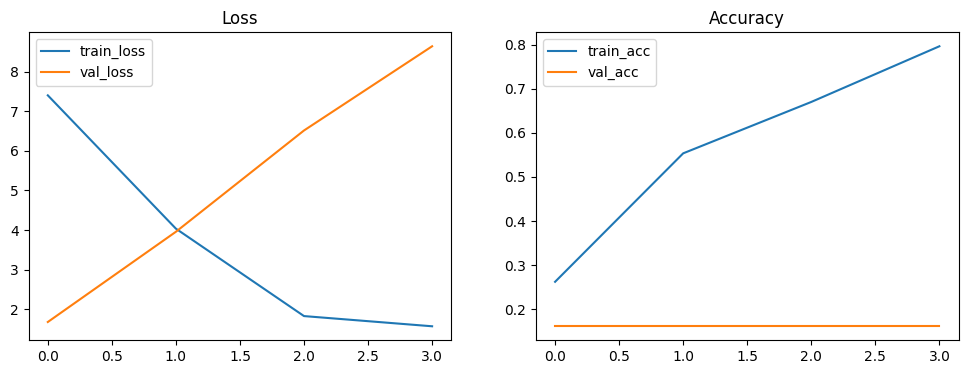

In [38]:
# Code: plot curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()


## Confusion matrix and quick misclassification analysis
This helps identify which classes are still confused.


c:\Users\PC\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
              precision    recall  f1-score   support

           0      0.200     0.200     0.200         5
           1      0.000     0.000     0.000         5
           2      0.000     0.000     0.000         5
           3      0.154     1.000     0.267         4
           4      0.000     0.000     0.000        12

    accuracy                          0.161        31
   macro avg      0.071     0.240     0.093        31
weighted avg      0.052     0.161     0.067        31



c:\Users\PC\venv\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\PC\venv\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\PC\venv\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


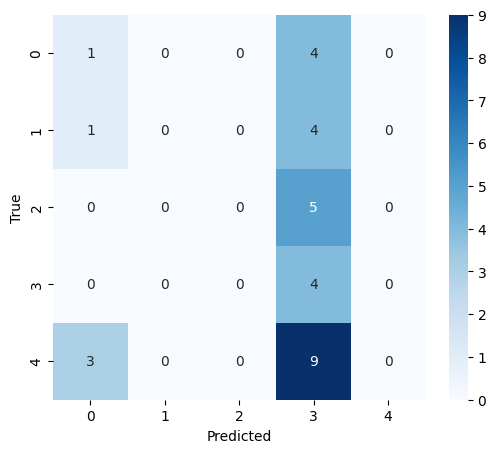

In [39]:
# Code: confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Build predictions on validation set (careful: generator yields batches)
val_gen.reset()
pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_gen.classes

print(classification_report(y_true, y_pred, digits=3))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


## Save the final model (already checkpointed, but also save final)
We save the final model to `models/` for inference scripts.


In [40]:
# Code: save final model
model.save("models/signvision_aug_final.keras")
print("Saved model to models/signvision_aug_final.keras")


Saved model to models/signvision_aug_final.keras


## Summary & Next steps
- We used strong on-the-fly augmentation combined with class weights to help model generalize.
- If some classes are still weak:
  - Add targeted augmentation (e.g., rotate only for a class).
  - Collect a few more real images for underperforming classes.
  - Try a pretrained backbone (MobileNetV2) with fine-tuning for higher accuracy.
- For real-time inference, convert the model to `.keras` or TFLite and use the same preprocessing (resize + rescale 1/255).


In [37]:
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# ==========================================
# FIX: Convert generators to NumPy arrays
# ==========================================

def generator_to_arrays(generator):
    """Convert ImageDataGenerator to numpy arrays"""
    X, y = [], []
    generator.reset()
    
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        X.append(x_batch)
        y.append(y_batch)
    
    X = np.concatenate(X)
    y = np.concatenate(y)
    return X, y

print("🔄 Converting training data to arrays...")
X_train, y_train = generator_to_arrays(train_gen)

print("🔄 Converting validation data to arrays...")  
X_val, y_val = generator_to_arrays(val_gen)

print(f"✅ Training data: {X_train.shape}, {y_train.shape}")
print(f"✅ Validation data: {X_val.shape}, {y_val.shape}")

# ==========================================
# Compute class weights (using original classes)
# ==========================================
labels = train_gen.classes
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights_values))
print("⚖️ Class Weights:", class_weights)

# ==========================================
# Verify model compatibility
# ==========================================
print(f"📊 Model input shape: {model.input_shape}")
print(f"📊 Model output shape: {model.output_shape}")
print(f"📊 Data input shape: {X_train.shape}")
print(f"📊 Data output shape: {y_train.shape}")

# ==========================================
# Callbacks
# ==========================================
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "models/signvision_v2_best.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# ==========================================
# TRAIN with arrays (no generators)
# ==========================================
EPOCHS = 25

print("🚀 Starting training with NumPy arrays...")
history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)

print("\n✅ Training complete!")

🔄 Converting training data to arrays...
🔄 Converting validation data to arrays...
✅ Training data: (103, 128, 128, 3), (103,)
✅ Validation data: (31, 128, 128, 3), (31,)
⚖️ Class Weights: {0: 1.2117647058823529, 1: 1.03, 2: 1.1444444444444444, 3: 1.2875, 4: 0.64375}
📊 Model input shape: (None, 128, 128, 3)
📊 Model output shape: (None, 5)
📊 Data input shape: (103, 128, 128, 3)
📊 Data output shape: (103,)
🚀 Starting training with NumPy arrays...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2351 - loss: 6.8270
Epoch 1: val_accuracy improved from -inf to 0.16129, saving model to models/signvision_v2_best.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.2371 - loss: 6.8679 - val_accuracy: 0.1613 - val_loss: 1.6812
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6518 - loss: 2.8404
Epoch 2: val_accuracy did not improve from 0.16129
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6448 - loss: 2.9258 - val_accuracy: 0.1613 - val_loss: 3.957